In [65]:
!pip install tensorflow

In [66]:
import tensorflow as tf # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B0  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations

In [5]:
"""from google.colab import drive
drive.mount('/content/drive')"""


"from google.colab import drive\ndrive.mount('/content/drive')"

In [67]:
import zipfile

zip_path = "/content/drive/MyDrive/E-Waste classification dataset.zip"
extract_path = "/content/E-Waste classification dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [68]:
trainpath = "/content/E-Waste classification dataset/modified-dataset/train"
testpath = "/content/E-Waste classification dataset/modified-dataset/test"
validpath = "/content/E-Waste classification dataset/modified-dataset/val"


In [69]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/E-Waste classification dataset.zip"

if not os.path.exists("/content/E-Waste classification dataset"):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/E-Waste classification dataset")
    print("Extracted zip.")
else:
    print("Already extracted.")


Already extracted.


In [8]:
"""from google.colab import files
uploaded = files.upload()"""

'from google.colab import files\nuploaded = files.upload()'

In [70]:
import os

for root, dirs, files in os.walk("E-Waste classification"):
    print(root)


In [71]:
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.


In [72]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [73]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [74]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


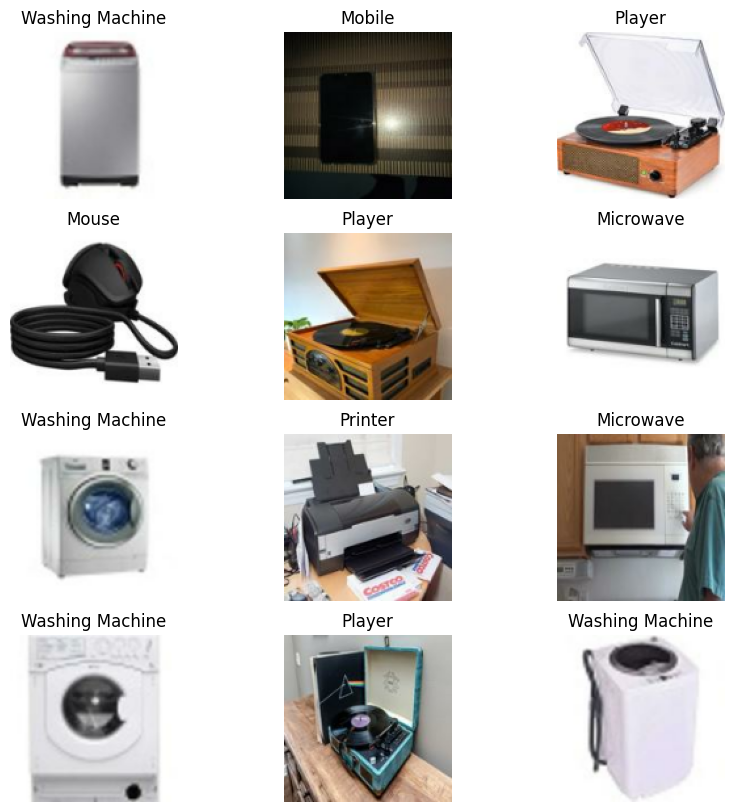

In [75]:

# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")


In [76]:
def plot_class_distribution(dataset, title="Class Distribution"):
    """
    Plots the number of items per class in a given dataset.

    Args:
        dataset: A tf.data.Dataset object created using image_dataset_from_directory
        title: Title for the plot (e.g., 'Train Data Distribution')
    """

    class_counts = {}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        # Convert labels tensor to numpy array and loop through each label
        for label in labels.numpy():
          class_name = dataset.class_names[label]  # Get class name using label index
            # Increment the count for this class
          #print(class_name)
          class_counts[class_name] = class_counts.get(class_name, 0) + 1
          class_names = list(class_counts.keys())
          counts = list(class_counts.values())
          # Create the bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(class_names, counts, color='skyblue')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot


#print(class_counts)


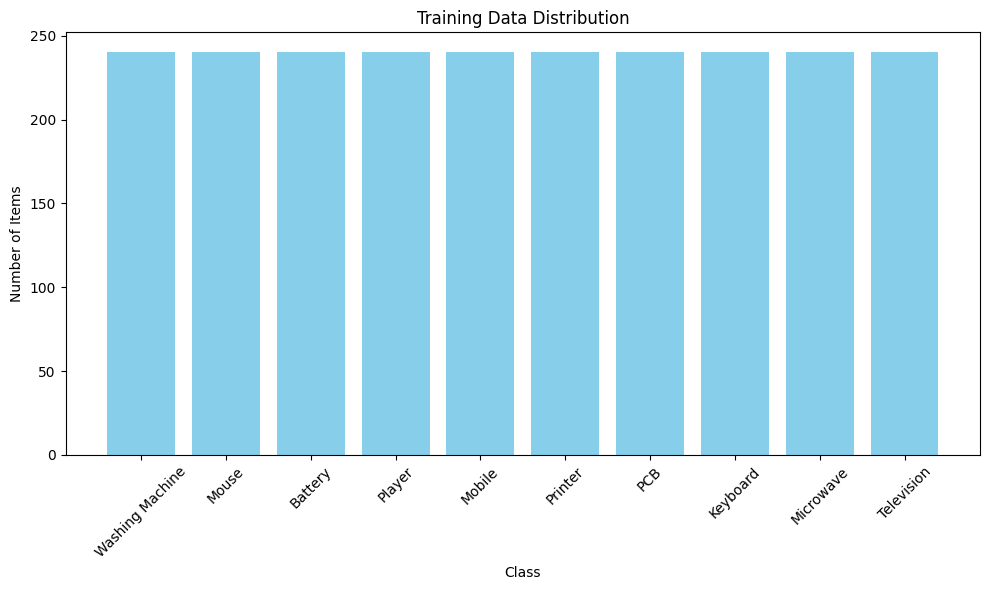

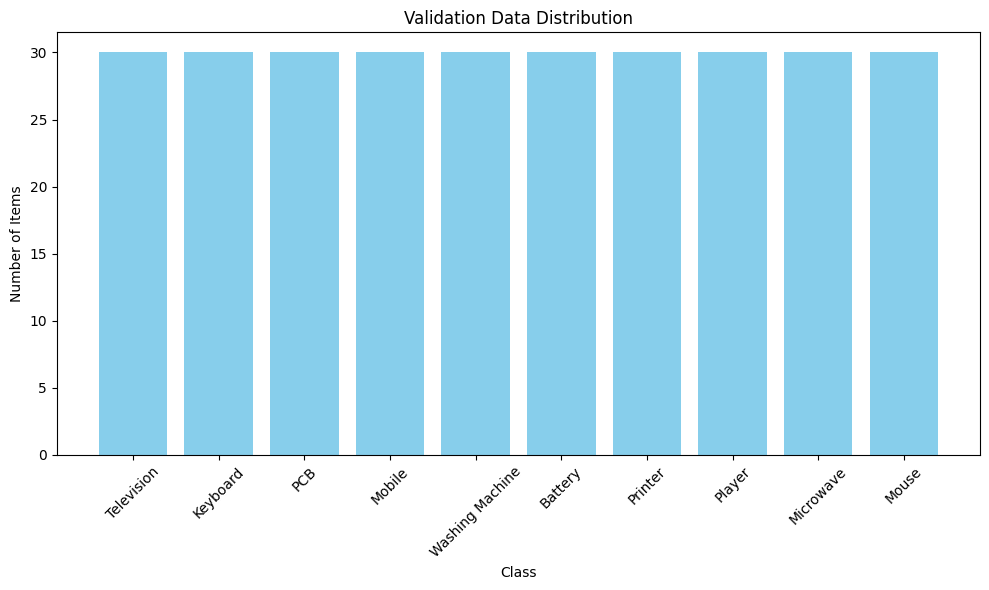

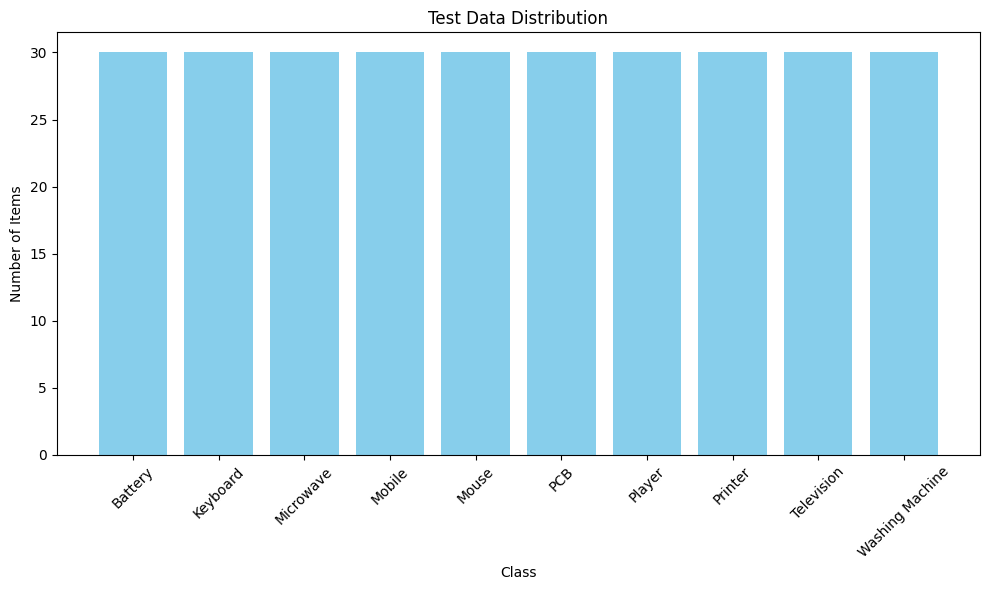

In [77]:
plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

In [78]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [80]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [81]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['Accuracy'])

In [82]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)


In [83]:
for batch in datatrain.take(5):
    print(batch)


(<tf.Tensor: shape=(32, 128, 128, 3), dtype=float32, numpy=
array([[[[ 90.58679 ,  79.58679 ,  57.586792],
         [ 92.75128 ,  81.75128 ,  59.75128 ],
         [ 95.387085,  84.387085,  62.387085],
         ...,
         [130.98224 , 119.98224 ,  99.98224 ],
         [128.53778 , 117.53778 ,  97.53778 ],
         [126.09332 , 115.09332 ,  95.09332 ]],

        [[ 95.77344 ,  84.77344 ,  62.773438],
         [ 95.96478 ,  84.96478 ,  62.964783],
         [ 96.94531 ,  85.94531 ,  63.945312],
         ...,
         [130.96173 , 119.96173 ,  99.446106],
         [129.14807 , 118.14807 ,  97.63245 ],
         [127.44519 , 116.44519 ,  95.929565]],

        [[ 99.25214 ,  88.25214 ,  66.25214 ],
         [ 98.97015 ,  87.97015 ,  65.97015 ],
         [ 99.71875 ,  88.71875 ,  66.71875 ],
         ...,
         [120.386475, 109.386475,  87.386475],
         [125.48657 , 114.48657 ,  92.48657 ],
         [131.01636 , 120.01636 ,  98.01636 ]],

        ...,

        [[100.26416 ,  88.26416 

In [84]:
# Set the number of epochs to train the model
epochs = 10
# Train the model on the training dataset 'datatrain'
history = model.fit(
    datatrain,                      # Training data generator or dataset
    validation_data=datavalid,      # Validation data generator or dataset
    epochs=epochs,                  # Number of training epochs
    batch_size=100,                 # Number of samples per gradient update
    callbacks=[early]               # List of callbacks to apply during training (e.g., early stopping)
)


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - Accuracy: 0.2689 - loss: 2.0958 - val_Accuracy: 0.8067 - val_loss: 1.0933
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - Accuracy: 0.7806 - loss: 0.9940 - val_Accuracy: 0.9100 - val_loss: 0.4916
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - Accuracy: 0.8784 - loss: 0.5197 - val_Accuracy: 0.9467 - val_loss: 0.2900
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - Accuracy: 0.9125 - loss: 0.3388 - val_Accuracy: 0.9633 - val_loss: 0.2155
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - Accuracy: 0.9252 - loss: 0.2472 - val_Accuracy: 0.9667 - val_loss: 0.1908
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - Accuracy: 0.9412 - loss: 0.1990 - val_Accuracy: 0.9733 - val_loss: 0.1762
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - Accuracy: 0.9602 - loss: 0.1514 - val_Accuracy: 0.9600 - val_loss: 0.1644
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - Accuracy: 0.9702 - loss: 0.1213 - val_Accuracy: 0.9633 - v

In [85]:
model.summary() # Print the architecture summary of the  model


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 4, 4, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,269,040 (62.06 MB)

 Trainable params: 5,168,458 (19.72 MB)

 Non-trainable params: 763,664 (2.91 MB)

 Optimizer params: 10,336,918 (39.43 MB)

In [86]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 128, 128,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 128, 128,  │          0 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ normalization_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 64, 64,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 32, 32,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 32, 32,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 32, 32,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 32, 32,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 32, 32,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 32, 32,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,155,648 (19.67 MB)

 Non-trainable params: 763,664 (2.91 MB)

In [87]:
### Plotting Training and Validation Accuracy and Loss Over Epochs

acc = history.history['Accuracy']           # Training accuracy
val_acc = history.history['val_Accuracy']   # Validation accuracy
loss = history.history['loss']              # Training loss
val_loss = history.history['val_loss']      # Validation loss

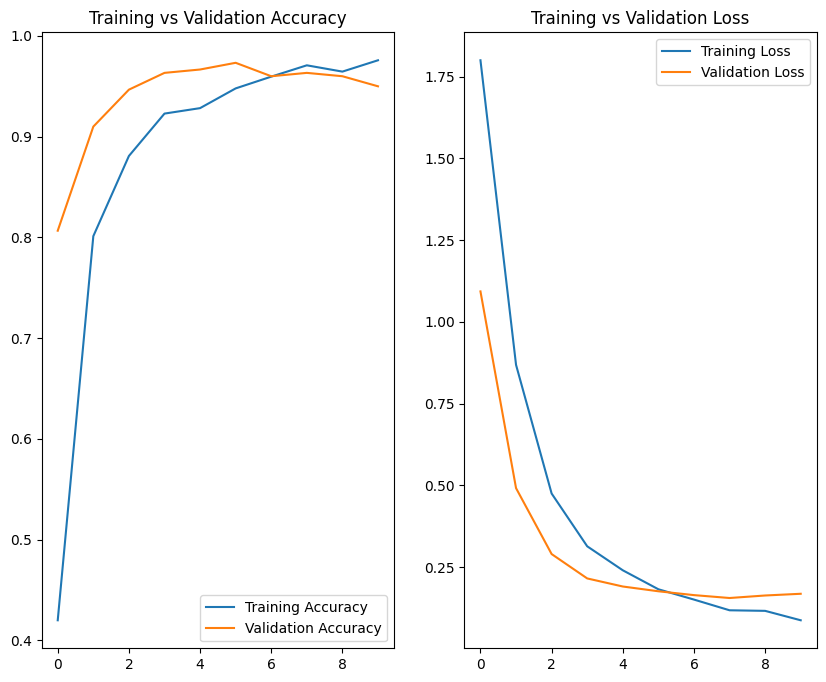

In [88]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot

plt.show()                                  # Display the plots


In [89]:
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 519ms/step - Accuracy: 0.9354 - loss: 0.1941
Test accuracy is0.9467, Test loss is 0.1447


In [90]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step
[[26  0  0  0  0  2  2  0  0  0]
 [ 1 29  0  0  0  0  0  0  0  0]
 [ 0  0 29  0  0  0  0  1  0  0]
 [ 0  0  0 29  0  1  0  0  0  0]
 [ 0  0  0  0 29  0  0  1  0  0]
 [ 0  0  0  0  0 29  1  0  0  0]
 [ 1  0  2  0  0  0 27  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0]
 [ 0  0  2  1  0  0  1  0 26  0]
 [ 0  0  0  0  0  0  0  0  0 30]]
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        30
           1       1.00      0.97      0.98        30
           2       0.88      0.97      0.92        30
           3       0.97      0.97      0.97        30
           4       1.00      0.97      0.98        30
           5       0.91      0.97      0.94        30
           6       0.87      0.90      0.89        30
           7       0.94      1.00      0.97        30
           8       1.00      0.87      0.93        30
           9       1.00      1.00      1.00        30

    accuracy                      

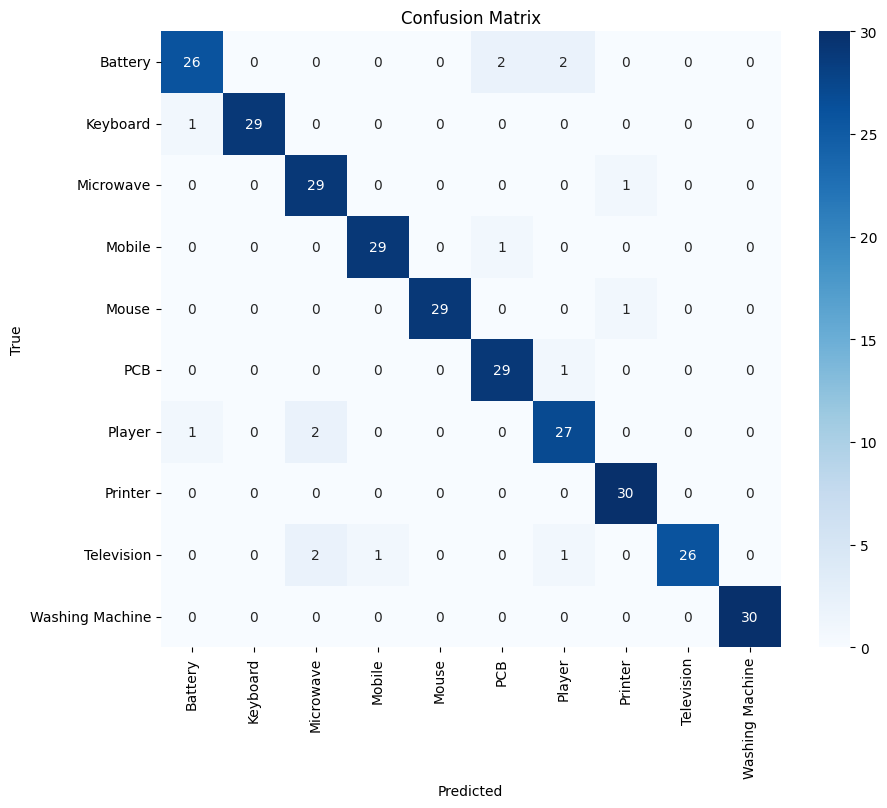

In [91]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()                                                                # Display the plot


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


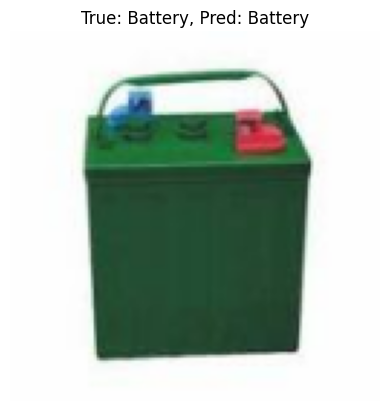

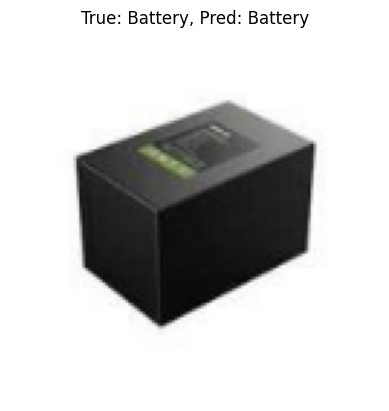

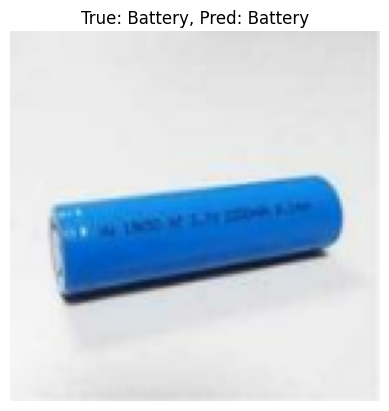

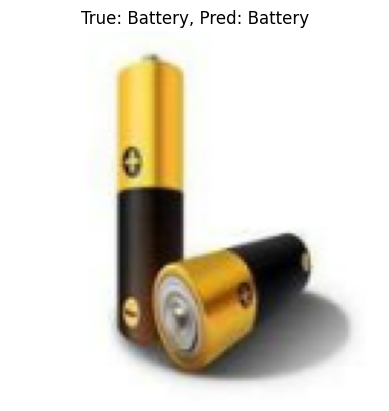

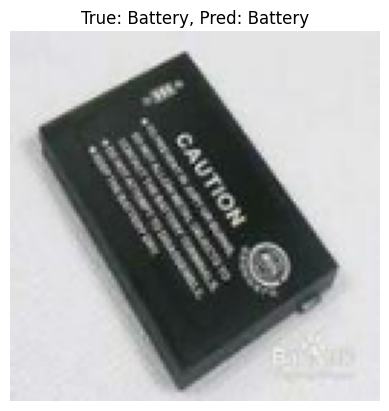

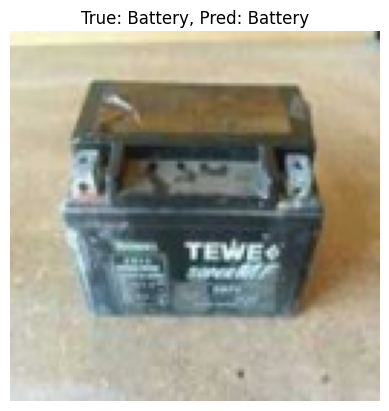

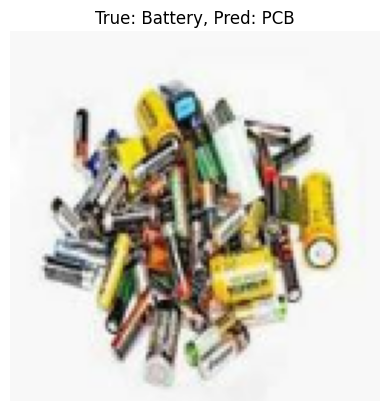

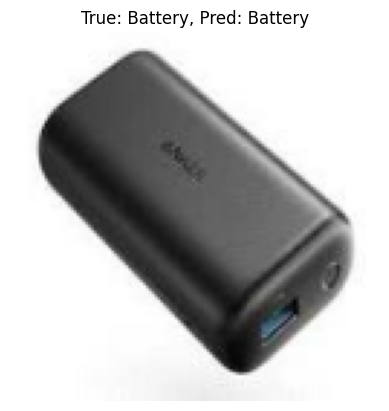

In [92]:
### Display Sample Predictions: True Labels vs Predicted Labels

class_names = datatest.class_names                                           # Get class names from test dataset

for images, labels in datatest.take(1):                                     # Take one batch from test data
    predictions = model.predict(images)                                     # Predict class probabilities
    pred_labels = tf.argmax(predictions, axis=1)                            # Get predicted class indices

    for i in range(8):                                                      # Display first 8 images from batch
        plt.imshow(images[i].numpy().astype("uint8"))                       # Convert tensor to image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Title with labels
        plt.axis("off")                                                     # Hide axes
        plt.show()                                                          # Show image



In [93]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Efficient_classify.keras')

In [94]:
# Define your class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Load your Keras model
model = tf.keras.models.load_model('Efficient_classify.keras')

In [95]:
!pip install gradio

In [96]:
def classify_image(img):
    # Step 1: Resize and convert to array
    img = img.resize((128, 128))
    img_array = np.array(img, dtype=np.float32)

    # Step 2: Preprocess and add batch dimension
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Step 3: Predict using the model
    prediction = model.predict(img_array)
    index = np.argmax(prediction)  # Get index of highest score

    # Step 4: Get class name and confidence
    class_name = class_names[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"



In [97]:
# Create a Gradio interface for the classify_image function
iface = gr.Interface(
    fn=classify_image,          # The function to run when input is given
    inputs=gr.Image(type="pil"), # Input component: expects an image as a PIL object
    outputs="text"              # Output component: displays the result as plain text
)

# Launch the Gradio interface, opening a local web app to interact with the model
iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d4ceb2b5ae2d36151d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
